<a href="https://colab.research.google.com/github/Mark-yank/Yolov8/blob/main/teste_lapisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importe e instalação das ferramentas utilizadas:

In [10]:
import torch
from IPython import display
display.clear_output()


In [11]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.9/78.2 GB disk)


In [12]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.16.0


In [13]:
from ultralytics import YOLO

modelo = YOLO('yolov8s.pt')

In [37]:
# COlOQUE O NOME DO VIDEO QUE FOI UTILIZADO E INDIQUE POR ONDE O CODIGO É RODADO
print("digite 1 se for pelo colab, caso contrario, digite 2")
selecao = int(input())
print("digite o nome do arquivo.extensão")
nome = str(input())
video_final = 'video_resultado.mp4'
if(selecao == 1):
    video_entrada = ('/content/'+nome)
    video_final= '/content/'+video_final
if(selecao == 2):
    video_entrada = nome
print(video_entrada)
print(video_final)

digite 1 se for pelo colab, caso contrario, digite 2
1
digite o nome do arquivo.extensão
video_pessoas.mp4
/content/video_pessoas.mp4
/content/video_resultado.mp4



0: 736x1280 12 persons, 2 cars, 5 traffic lights, 4 handbags, 1 suitcase, 103.0ms
Speed: 11.6ms preprocess, 103.0ms inference, 44.0ms postprocess per image at shape (1, 3, 736, 1280)


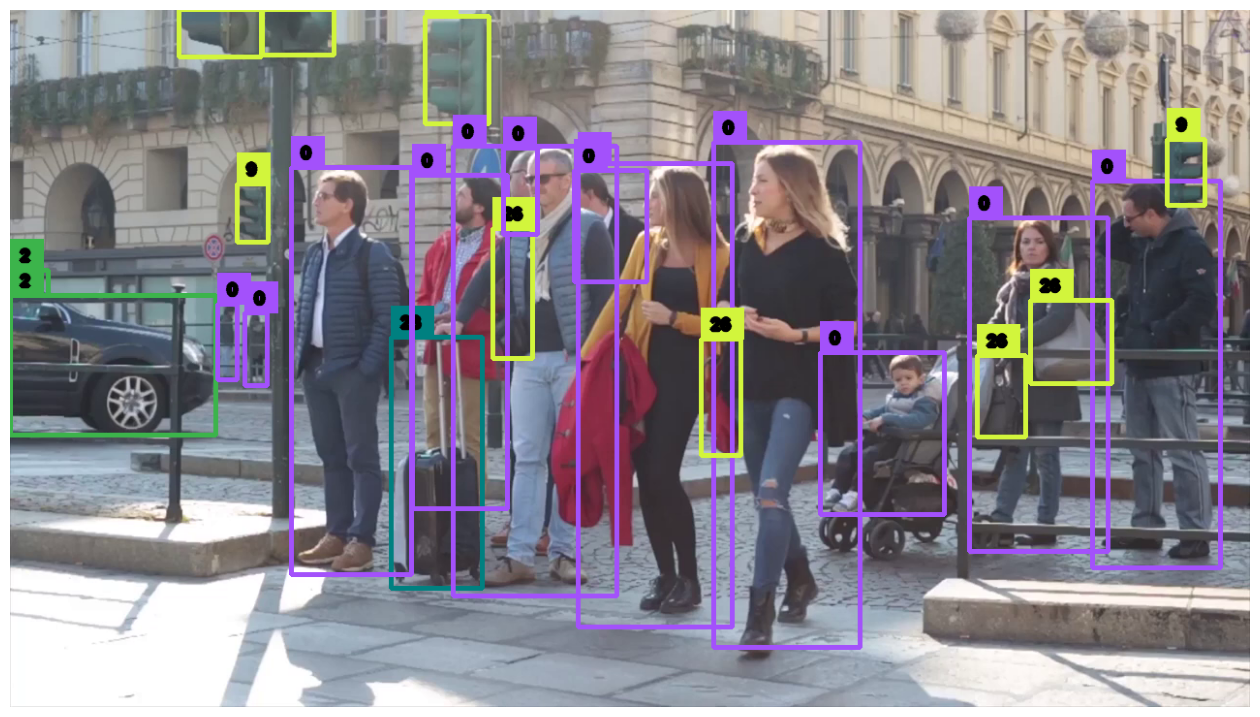

In [19]:
#ULIZAÇÃO DA BIBLIOTECA SUPERVISION PARA MARCAR AS PESSOAS IDENTIFICADAS DO APOS NOSSO PROCESSO DE ANALISE PELO YOLOv8
#FOI UTILIZADA APENAS O PRIMEIRO FRAME DO VIDEO PARA CONFERIR A IDENTIFICAÇÃO E A MARCAÇÃO
import supervision as sv
# extract video frame
generator = sv.get_video_frames_generator(video_entrada)
iterator = iter(generator)
frame = next(iterator)

# detect
results = modelo(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4)
frame = box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.plot_image(frame, (16, 16))


0: 736x1280 12 persons, 2 cars, 5 traffic lights, 4 handbags, 1 suitcase, 30.5ms
Speed: 4.0ms preprocess, 30.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


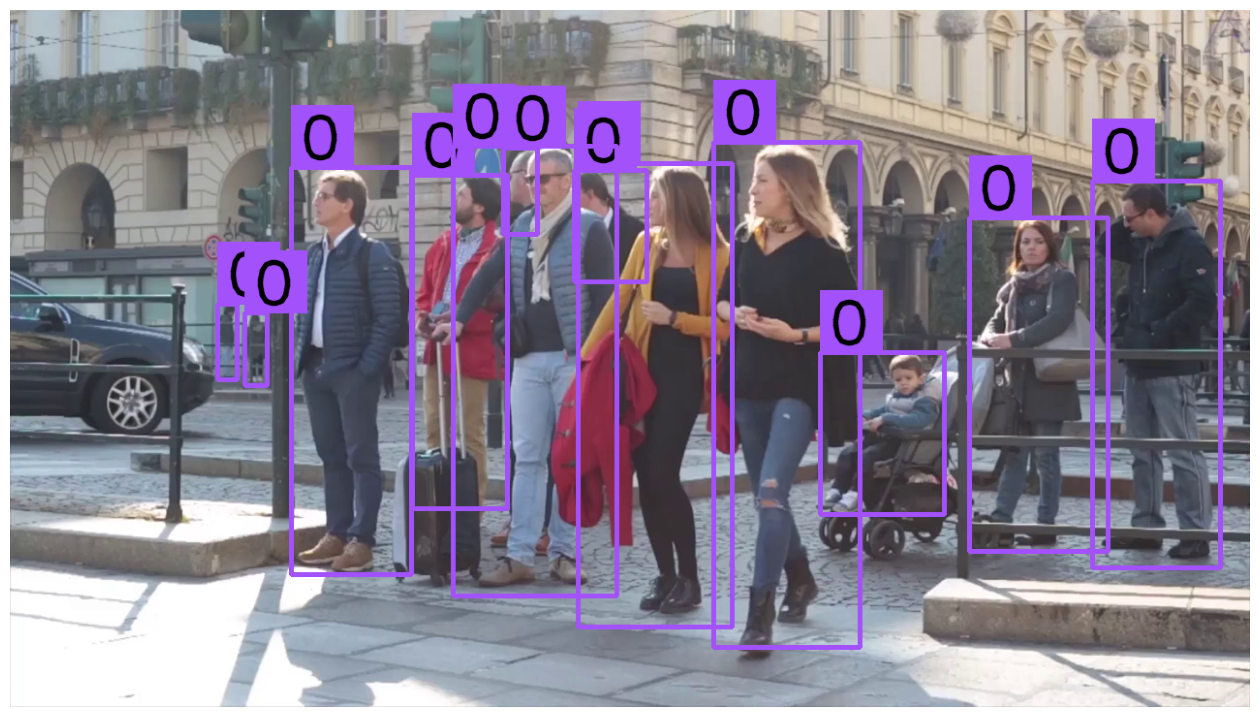

In [20]:
#VISTO QUE O PRIMEIRO FRAME NÃO EXISTE NENHUM PROBLEMA RELATIVO A IDENTIFCAÇÃO
#FOI APLICADO UM FILTRO PARA QUE A UNICA CLASSE A SER IDENTIFICADA PELO NOSSO MODELO DO YOLO SEJA A CLASSE 0
#CLASSE 0 REPRESENTA A CATEGORIA: HUMANO. TIRANDO ASSIM IDENTIFICAÇÕES DESNECESSARIAS
import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator(video_entrada)
iterator = iter(generator)
frame = next(iterator)

# detect
results = modelo(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)
detections = detections[detections.class_id == 0]

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
frame = box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.plot_image(frame, (16, 16))

In [21]:
#COMANDO QUE SERVE PRINCIPALMENTE PARA PEGAR O TAMANHO DA IMAGEM RELATIVA AO VIDEO
#O TAMANHO É IMPORTANTE DE SABER JÁ QUE PARA CONTAR AS PESSOAS, SERÁ NECESSARIO DEMARCAR UMA AREA ONDE VAMOS CONTAR
#OS OBJETOS IDENTIFICADOS, NO CASO PESSOAS, E A AREA SERÁ TODO O VIDEO
sv.VideoInfo.from_video_path(video_entrada)

VideoInfo(width=1280, height=720, fps=23, total_frames=188)


0: 736x1280 12 persons, 2 cars, 5 traffic lights, 4 handbags, 1 suitcase, 29.7ms
Speed: 3.8ms preprocess, 29.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


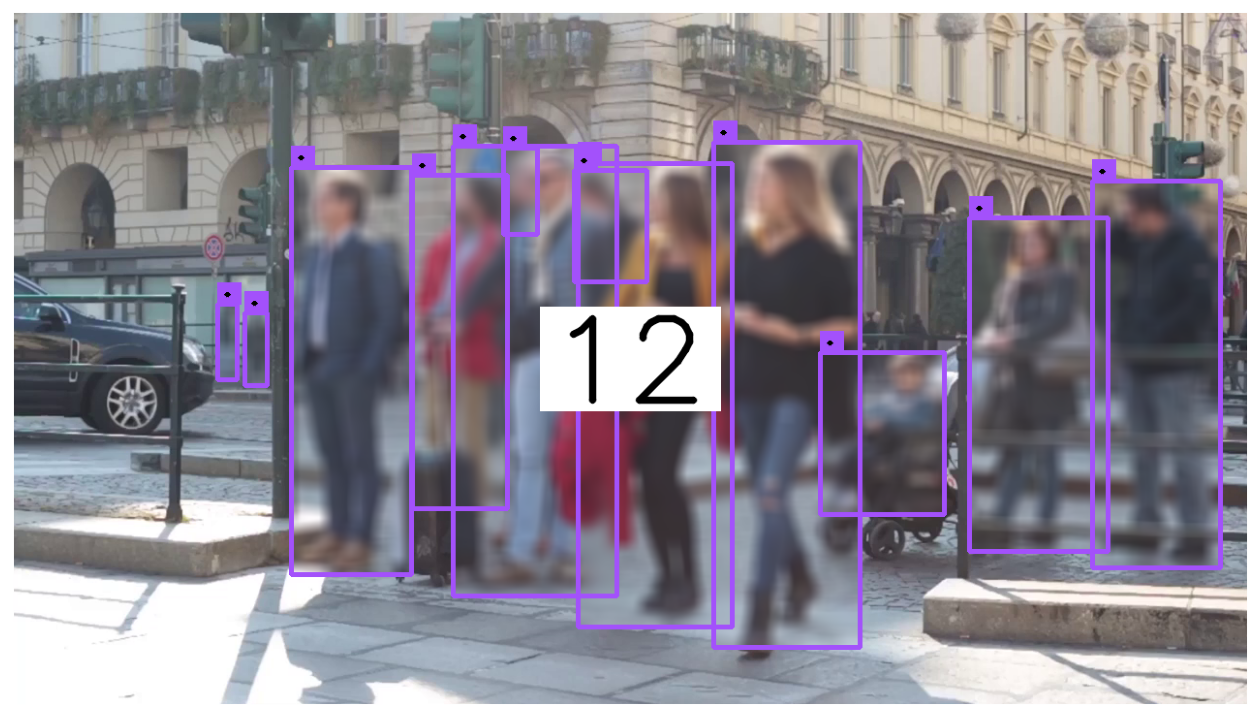

In [29]:
#TESTE DE CONTAGEM DE PESSOAS(OBJETOS) IDENTIFICADOS
import numpy as np
import supervision as sv

#DELIMITAR A AREA ONDE SERÁ FEITA A CONTAGEM DOS OBJETOS IDENTIFICADOS
polygon = np.array([
    [0, 0],
    [1280, 0],
    [1280, 720],
    [0, 720]
])

video_info = sv.VideoInfo.from_video_path(video_entrada)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

#INICIALIZAR OS MARCADORES ONDE MOSTRA OS OBJETOS
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

#SELECIONA O PRIMEIRO FRAME DO VIDEO PARA TESTE
generator = sv.get_video_frames_generator(video_entrada)
iterator = iter(generator)
frame = next(iterator)

#ONDE SERÁ FEITO A IDENTIFICAÇÃO COM O YOLO(modelo) E AUXILIADO PELO SuperVision PARA MARCAR OS OBJETOS
results = modelo(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

#DEMOSTRAÇÃO DO RESULTADO COM AS PESSOAS MARCADAS, O NUMERO DE IDENTIFICADOS E AS IMAGENS BORRADAS
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=0)
blur_annotator = sv.BlurAnnotator()
frame = blur_annotator.annotate(scene=frame, detections=detections)
frame = box_annotator.annotate(scene=frame, detections=detections)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.plot_image(frame, (16, 16))

In [30]:
#APLICAÇÃO DO PROGRAMA NO VIDEO TODO
import numpy as np
import supervision as sv

#DELIMITAR A AREA ONDE SERÁ FEITA A CONTAGEM DOS OBJETOS IDENTIFICADOS
polygon = np.array([
    [0, 0],
    [1280, 0],
    [1280, 720],
    [0, 720]
])
video_info = sv.VideoInfo.from_video_path(video_entrada)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

#INICIALIZAR OS MARCADORES ONDE MOSTRA OS OBJETOS
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

def process_frame(frame: np.ndarray, _) -> np.ndarray:
    #ONDE SERÁ FEITO A IDENTIFICAÇÃO COM O YOLO(modelo) E AUXILIADO PELO SuperVision PARA MARCAR OS OBJETOS
    results = modelo(frame, imgsz=1280)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[detections.class_id == 0]
    zone.trigger(detections=detections)

    #DEMOSTRAÇÃO DO RESULTADO COM AS PESSOAS MARCADAS, O NUMERO DE IDENTIFICADOS E AS IMAGENS BORRADAS
    box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=0)
    blur_annotator = sv.BlurAnnotator()
    frame = blur_annotator.annotate(scene=frame, detections=detections)
    frame = box_annotator.annotate(scene=frame, detections=detections)
    frame = zone_annotator.annotate(scene=frame)

    return frame
#AAPLICAÇÃO DO PROCESSO NO VIDEO E SALVAR O RESULTADO NA PASTA
sv.process_video(source_path=video_entrada, target_path=video_final, callback=process_frame)

from IPython import display
display.clear_output()

In [44]:
import os
video_final = '/content/video_resultado.mp4'
video_demostração = '/content/video_demostração.mp4'
os.system(f"ffmpeg -i {video_final} -vcodec libx264 {video_demostração}")

0

In [45]:
#METODO PARA TER A VISUALIZAÇÃO DO VIDEO SALVO NO PROPRIO NOTEBOOK
def exibir_video(video_caminho):
  from IPython.display import HTML
  from base64 import b64encode
  mp4 = open(video_caminho, 'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
      <video width=500 controls>
        <source src="%s" type="video/mp4"
      </video>
      """ % data_url)

In [46]:
#VISUALIZAÇÃO DO VIDEO
exibir_video(video_demostração)